Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."


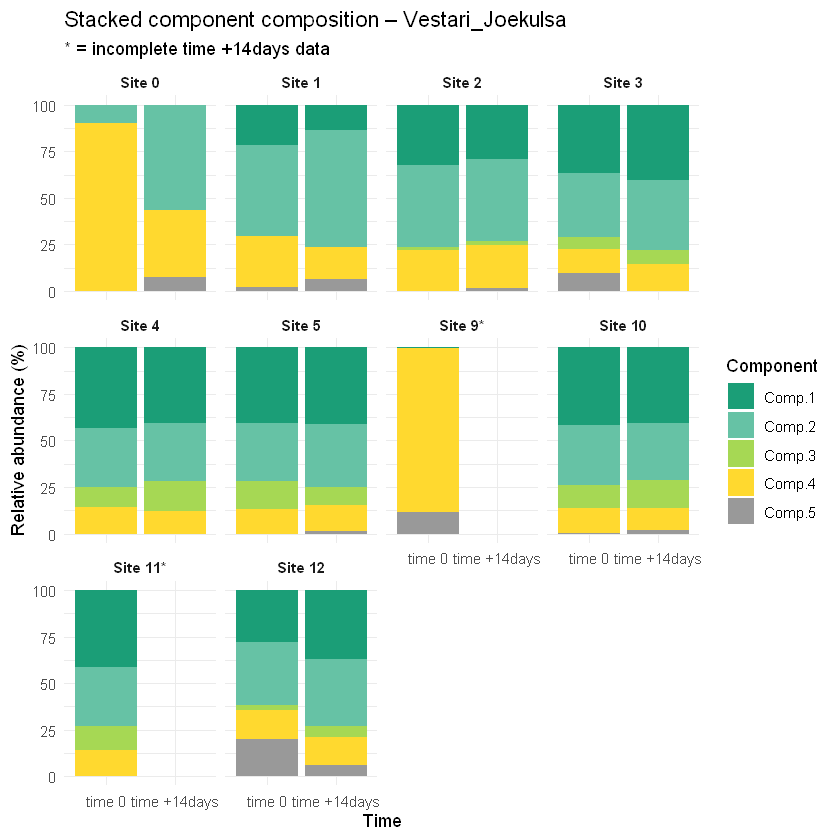

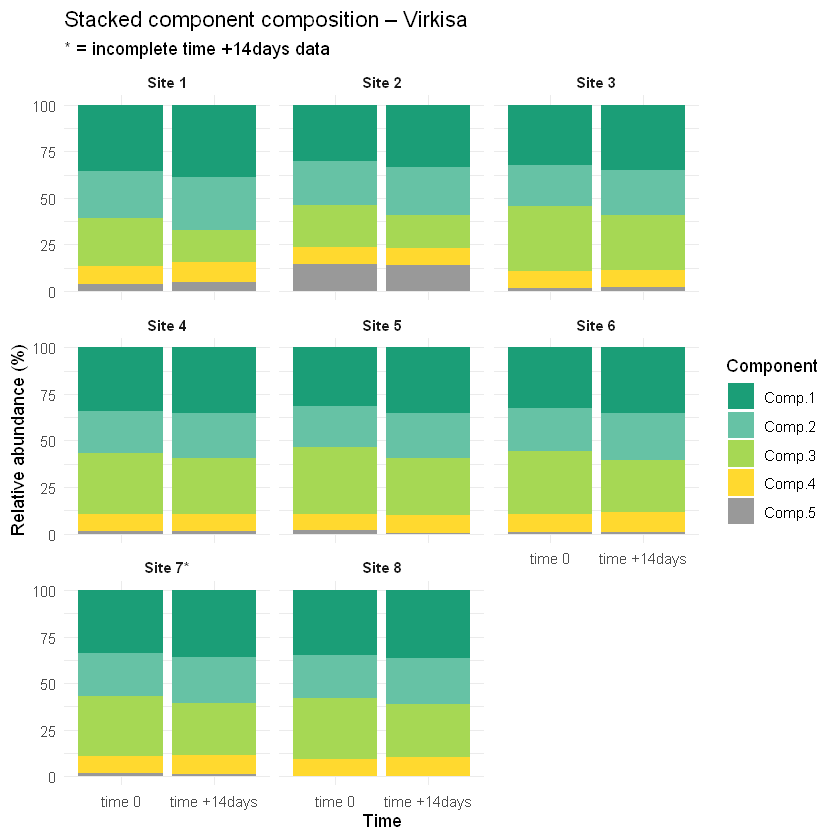

In [7]:
## Hüsch und final

# Load packages
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Load Excel file
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path)

# 2. Identify problematic sites where sum of time+14days components ≠ 100%
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3. Transform data to long format
df_long <- df %>%
  # time 0
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # time +14days
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4. Calculate mean and normalize to 100% per site and timepoint
df_normalized <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5. Mark problematic sites with *
df_normalized <- df_normalized %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel = ifelse(is_problem,
                       paste0("Site ", site_nr, "*"),
                       paste0("Site ", site_nr))
  )

# 6. Sort sites numerically
site_order <- df_normalized %>%
  distinct(site_nr, SiteLabel) %>%
  arrange(site_nr) %>%
  pull(SiteLabel)

df_normalized$SiteLabel <- factor(df_normalized$SiteLabel, levels = site_order)

# 7. Component labels and new gradient-inspired color palette
component_labels <- c(
  "pctComp.1" = "Comp.1",
  "pctComp.2" = "Comp.2",
  "pctComp.3" = "Comp.3",
  "pctComp.4" = "Comp.4",
  "pctComp.5" = "Comp.5"
)

component_colors <- c(
  "Comp.1" = "#1b9e77",  # kräftiges Türkis-Grün
  "Comp.2" = "#66c2a5",  # helleres Türkis
  "Comp.3" = "#a6d854",  # gelb-grün
  "Comp.4" = "#ffd92f",  # gelb
  "Comp.5" = "#999999"   # grau
)

# Apply labels
df_normalized$ComponentLabel <- component_labels[as.character(df_normalized$Component)]
df_normalized$ComponentLabel <- factor(df_normalized$ComponentLabel, levels = names(component_colors))

# 8. Plot by river
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)",
      fill = "Component"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


In [2]:
df_river %>% filter(is.na(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


In [3]:
df_river %>% filter(Percent < 0 | Percent > 100 | is.infinite(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


💬 Zusammenfassung

    ✅ Kein NA → geprüft ✔️

    ✅ Kein <0 oder >100 → geprüft ✔️

    ✅ Keine unendlichen Werte → geprüft ✔️

    ✅ Warnung kommt nur von leeren Slots bei Facets → harmlos

## Speichern

In [8]:
# Vestari 5
# Virkisa 4 Säulen in einer Zeile


# Bibliotheken laden
library(ggplot2)
library(dplyr)

# Verzeichnis zum Speichern
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"

# Optional: Ordner anlegen
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Für jede River-Plot speichern
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)
  
  # ncol je nach Fluss bestimmen
  if (river == "Vestari_Joekulsa") {
    ncol_value <- 5
  } else if (river == "Virkisa") {
    ncol_value <- 4
  } else {
    ncol_value <- 4  # Standard-Fallback
  }
  
  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed", ncol = ncol_value) +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Component distribution in DOC samples –", river),
      subtitle = "* = incomplete data at time +14 days",
      x = "Incubation time point", y = "Relative proportion (%)",
      fill = "Component"
    ) +
    theme_minimal() +
    theme(
      strip.text = element_text(face = "bold"),
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 10),
      axis.text = element_text(size = 9),
      axis.title = element_text(size = 11),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 9)
    )
  
  # Dateiname
  file_name <- paste0(output_dir, "/", river, "_Saeulen.png")
  
  # Grafik speichern (kompakter, quer)
  ggsave(
    filename = file_name,
    plot = p,
    width = 25,    # kompakter als A4 quer
    height = 18,
    units = "cm",
    dpi = 300
  )
}


Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."


### als Tabellen

In [15]:
library(dplyr)
library(tidyr)

# Time-Faktor vorbereiten
df_long <- df_long %>%
  mutate(Time = factor(Time, levels = c("time 0", "time +14days")))

# Normalisiert
df_summary_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

# Pro Fluss Tabellen
rivers <- unique(df_summary_norm$river_name)

tables_norm <- list()

for (river in rivers) {
  df_river <- df_summary_norm %>% filter(river_name == river)
  
  # Component-Namen schöner
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  # Pivot
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_norm[[river]] <- df_pivot
}

tables_norm


$Vestari_Joekulsa
# A tibble: 5 × 22
  river_name   Component `0_time 0` `0_time +14days` `1_time 0` `1_time +14days`
  <chr>        <chr>          <dbl>            <dbl>      <dbl>            <dbl>
1 Vestari_Joe… Comp.1          0                 0        21.9             13.7 
2 Vestari_Joe… Comp.2          9.76             56.6      48.5             62.9 
3 Vestari_Joe… Comp.3          0.23              0         0.21             0.01
4 Vestari_Joe… Comp.4         90.0              35.9      27.2             17.2 
5 Vestari_Joe… Comp.5          0                 7.5       2.22             6.22
# ℹ 16 more variables: `2_time 0` <dbl>, `2_time +14days` <dbl>,
#   `3_time 0` <dbl>, `3_time +14days` <dbl>, `4_time 0` <dbl>,
#   `4_time +14days` <dbl>, `5_time 0` <dbl>, `5_time +14days` <dbl>,
#   `9_time 0` <dbl>, `9_time +14days` <dbl>, `10_time 0` <dbl>,
#   `10_time +14days` <dbl>, `11_time 0` <dbl>, `11_time +14days` <dbl>,
#   `12_time 0` <dbl>, `12_time +14days` <dbl>

$Virkisa
# A tibble: 5 × 18
  river_name Component `1_time 0` `1_time +14days` `2_time 0` `2_time +14days`
  <chr>      <chr>          <dbl>            <dbl>      <dbl>            <dbl>
1 Virkisa    Comp.1         35.8             38.6        30.4            33.4 
2 Virkisa    Comp.2         24.9             28.6        23.2            25.9 
3 Virkisa    Comp.3         25.9             17.4        22.9            17.4 
4 Virkisa    Comp.4          9.91            10.8         8.9             9.63
5 Virkisa    Comp.5          3.46             4.51       14.5            13.6 
# ℹ 12 more variables: `3_time 0` <dbl>, `3_time +14days` <dbl>,
#   `4_time 0` <dbl>, `4_time +14days` <dbl>, `5_time 0` <dbl>,
#   `5_time +14days` <dbl>, `6_time 0` <dbl>, `6_time +14days` <dbl>,
#   `7_time 0` <dbl>, `7_time +14days` <dbl>, `8_time 0` <dbl>,
#   `8_time +14days` <dbl>

In [16]:
# Unnormalisiert
df_summary_raw <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

tables_raw <- list()

for (river in rivers) {
  df_river <- df_summary_raw %>% filter(river_name == river)
  
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_raw[[river]] <- df_pivot
}

tables_raw


$Vestari_Joekulsa
# A tibble: 5 × 22
  river_name   Component `0_time 0` `0_time +14days` `1_time 0` `1_time +14days`
  <chr>        <chr>          <dbl>            <dbl>      <dbl>            <dbl>
1 Vestari_Joe… Comp.1           0               0          0.22             0.14
2 Vestari_Joe… Comp.2           0.1             0.57       0.49             0.63
3 Vestari_Joe… Comp.3           0               0          0                0   
4 Vestari_Joe… Comp.4           0.9             0.36       0.27             0.17
5 Vestari_Joe… Comp.5           0               0.07       0.02             0.06
# ℹ 16 more variables: `2_time 0` <dbl>, `2_time +14days` <dbl>,
#   `3_time 0` <dbl>, `3_time +14days` <dbl>, `4_time 0` <dbl>,
#   `4_time +14days` <dbl>, `5_time 0` <dbl>, `5_time +14days` <dbl>,
#   `9_time 0` <dbl>, `9_time +14days` <dbl>, `10_time 0` <dbl>,
#   `10_time +14days` <dbl>, `11_time 0` <dbl>, `11_time +14days` <dbl>,
#   `12_time 0` <dbl>, `12_time +14days` <dbl>

$Virkisa
# A tibble: 5 × 18
  river_name Component `1_time 0` `1_time +14days` `2_time 0` `2_time +14days`
  <chr>      <chr>          <dbl>            <dbl>      <dbl>            <dbl>
1 Virkisa    Comp.1          0.36             0.39       0.3              0.33
2 Virkisa    Comp.2          0.25             0.29       0.23             0.26
3 Virkisa    Comp.3          0.26             0.17       0.23             0.17
4 Virkisa    Comp.4          0.1              0.11       0.09             0.1 
5 Virkisa    Comp.5          0.03             0.05       0.15             0.14
# ℹ 12 more variables: `3_time 0` <dbl>, `3_time +14days` <dbl>,
#   `4_time 0` <dbl>, `4_time +14days` <dbl>, `5_time 0` <dbl>,
#   `5_time +14days` <dbl>, `6_time 0` <dbl>, `6_time +14days` <dbl>,
#   `7_time 0` <dbl>, `7_time +14days` <dbl>, `8_time 0` <dbl>,
#   `8_time +14days` <dbl>

### ..